In [1]:
!pip install -Uq gpytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 3.2 MB/s eta 0:00:00


In [8]:
import tqdm
import math
import torch
import numpy as np

import torch.distributions as dist

import gpytorch
import pandas as pd
from matplotlib import pyplot as plt

In [9]:
import math
from numbers import Number, Real

import torch
from torch.distributions import constraints
from torch.distributions.exp_family import ExponentialFamily
from torch.distributions.utils import _standard_normal, broadcast_all

class CensoredNormal(ExponentialFamily):
    """
    Creates a censored normal (also called Gaussian) distribution parameterized by
    :attr:`loc` and :attr:`scale` and :attr:`low`  and :attr:`high`

    Example::

        >>> # xdoctest: +IGNORE_WANT("non-deterministic")
        >>> m = CensoredNormal(
          torch.tensor([0.0]), torch.tensor([1.0]),
          torch.tensor([-0.5]), torch.tensor([0.5])
          )
        >>> m.sample(sample_shape=(3,1))
        tensor([[0.5000],
            [0.5000],
            [0.1836]])
        tensor([ 0.1046])

    Args:
        loc (float or Tensor): mean of the base normal distribution (often referred to as mu) to which the censoring is applied
        scale (float or Tensor): standard deviation of the base normal distribution to which the censoring is applied
        low (float or Tensor): lower censoring boundary
        high (float or Tensor): upper censoring boundary
    """
    arg_constraints = {
        "loc": constraints.real,
        "scale": constraints.positive,
        "low": constraints.dependent(is_discrete=False, event_dim=0),
        "high": constraints.dependent(is_discrete=False, event_dim=0)}
    has_rsample = True
    _mean_carrier_measure = 0

    @property
    def mean(self):
        x_high = (self.high - self.loc)/self.scale
        cdf_high = self._normal_cdf(self.high)
        pdf_high = math.exp(self._normal_log_prob(self.high))
        x_low = (self.low - self.loc)/self.scale
        cdf_low = self._normal_cdf(self.low)
        pdf_low = math.exp(self._normal_log_prob(self.low))
        term1 = cdf_high - cdf_low
        term2 = pdf_high - pdf_low
        return self.loc * term1 - self.scale * term2

    @property
    def stddev(self):
        return self.variance.sqrt()

    @property
    def variance(self):
        x_high = (self.high - self.loc)/self.scale
        cdf_high = self._normal_cdf(self.high)
        pdf_high = math.exp(self._normal_log_prob(self.high))
        x_low = (self.low - self.loc)/self.scale
        cdf_low = self._normal_cdf(self.low)
        pdf_low = math.exp(self._normal_log_prob(self.low))
        term1 = cdf_high - cdf_low
        term2 = x_high * pdf_high - x_low * pdf_low
        return  (self.scale ** 2) * (term1 - term2)


    def __init__(self, loc, scale, low, high, validate_args=None):
        self.loc, self.scale, self.low, self.high = broadcast_all(loc, scale, low, high)
        if isinstance(loc, Number) and isinstance(scale, Number) and isinstance(low, Number) and isinstance(high, Number):
            batch_shape = torch.Size()
        else:
            batch_shape = self.loc.size()
        support = constraints.interval(low, high)
        super().__init__(batch_shape, validate_args=validate_args)

    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(CensoredNormal, _instance)
        batch_shape = torch.Size(batch_shape)
        new.loc = self.loc.expand(batch_shape)
        new.scale = self.scale.expand(batch_shape)
        new.low = self.low.expand(batch_shape)
        new.high = self.high.expand(batch_shape)
        super(CensoredNormal, new).__init__(batch_shape, validate_args=False)
        new._validate_args = self._validate_args
        return new

    @constraints.dependent_property(is_discrete=False, event_dim=0)
    def support(self):
        return constraints.interval(self.low, self.high)


    def sample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        with torch.no_grad():
            samples = torch.normal(self.loc.expand(shape), self.scale.expand(shape))
            return samples.clamp(min=self.low, max=self.high)


    def rsample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        eps = _standard_normal(shape, dtype=self.loc.dtype, device=self.loc.device)
        rsamples =  self.loc + eps * self.scale
        return rsamples.clamp(min=self.low, max=self.high)

    def pdf(self, value):
        if self._validate_args:
            self._validate_sample(value)
        probs = torch.exp(self.log_prob(value))
        lower_cdf_mass = self._normal_cdf(self.low)
        upper_cdf_mass = self._normal_cdf(-self.high)
        probs = torch.where(value <= self.low, lower_cdf_mass, probs)
        probs = torch.where(value >= self.high, upper_cdf_mass, probs)
        return probs

    def log_prob(self, value, jitter=1e-12):
        """jitter: used to bounce off NormCDF from 0 before applying log """
        if self._validate_args:
            self._validate_sample(value)
        log_probs = self._normal_log_prob(value)
        lower_log_cdf_mass = math.log(self._normal_cdf(self.low) + jitter) if isinstance(self._normal_cdf(self.low) + jitter,
                                                                                                Number) else (self._normal_cdf(self.low) + jitter).log()
        upper_log_cdf_mass = math.log(self._normal_cdf(-self.high) + jitter) if isinstance(self._normal_cdf(-self.high) + jitter,
                                                                                                    Number) else (self._normal_cdf(-self.high) + jitter).log()
        log_probs = torch.where(value <= self.low, lower_log_cdf_mass, log_probs)
        log_probs = torch.where(value >= self.high, upper_log_cdf_mass, log_probs)
        return log_probs

    def cdf(self, value):
        if self._validate_args:
            self._validate_sample(value)
        cdf_ = self._normal_cdf(value)
        cdf_ = torch.where(value < self.low, 0, cdf_)
        cdf_ = torch.where(value > self.high, 1, cdf_)
        return cdf_

    def icdf(self, value):
        result = self._normal_icdf(value)
        return result.clamp(min=self.low, max=self.high)

    def entropy(self, jitter=1e-12):
        x_low = (self.low - self.loc)/self.scale
        x_high = (self.high - self.loc)/self.scale
        logcdf_x_low = math.log(self._normal_cdf(self.low) + jitter) if isinstance(self._normal_cdf(self.low) + jitter,
                                                                                                  Number) else (self._normal_cdf(self.low) + jitter).log()
        logcdf_x_high = math.log(self._normal_cdf(-self.high) + jitter) if isinstance(self._normal_cdf(-self.high) + jitter,
                                                                                                      Number) else (self._normal_cdf(-self.high) + jitter).log()

        term1 = self._normal_entropy() * (self._normal_cdf(self.high)- self._normal_cdf(self.low))
        term2 = 0.5 * (x_high * torch.exp(self._normal_log_prob(self.high)) - x_low * torch.exp(self._normal_log_prob(self.low)))
        term3 = logcdf_x_high * (self._normal_cdf(-self.high)) -  logcdf_x_low * self._normal_cdf(self.low)
        return term1 - term2 - term3


    def _normal_log_prob(self, value):
            # compute the variance
            var = self.scale**2
            log_scale = (
                math.log(self.scale) if isinstance(self.scale, Real) else self.scale.log()
            )
            return (
                -((value - self.loc) ** 2) / (2 * var)
                - log_scale
                - math.log(math.sqrt(2 * math.pi))
            )

    def _normal_cdf(self, value):
        return 0.5 * (
            1 + torch.erf((value - self.loc) * self.scale.reciprocal() / math.sqrt(2))
        )

    def _normal_icdf(self, value):
        return self.loc + self.scale * torch.erfinv(2 * value - 1) * math.sqrt(2)


    def _normal_entropy(self):
        return 0.5 + 0.5 * math.log(2 * math.pi) + torch.log(self.scale)

    @property
    def _normal_natural_params(self):
        return (self.loc / self.scale.pow(2), -0.5 * self.scale.pow(2).reciprocal())

    def _log_normalizer(self, x, y):
        return -0.25 * x.pow(2) / y + 0.5 * torch.log(-math.pi / y)

In [47]:
import warnings
from typing import Any

import torch
from linear_operator.operators import LinearOperator, ZeroLinearOperator
from torch import Tensor
from torch.distributions import Distribution, Normal

from gpytorch.constraints import Interval
from gpytorch.distributions import base_distributions, MultivariateNormal
from gpytorch.priors import Prior
from gpytorch.utils.warnings import GPInputWarning
from gpytorch.likelihoods.likelihood import _Likelihood, _OneDimensionalLikelihood


class CensoredGaussianLikelihood(_Likelihood):
    """Base class for Censored Gaussian Likelihoods."""
    def __init__(self, variance=None, low=None, high=None) -> None:
        super().__init__()

        variance = torch.tensor(1.) if variance is None else variance
        self.noise = gpytorch.likelihoods.noise_models.HomoskedasticNoise()
        self.noise.initialize(noise=variance)
        self.low = low
        self.high = high

    @property
    def variance(self):
      return self.noise.noise

    def forward(self, function_samples: Tensor, *params: Any, **kwargs: Any):
        return CensoredNormal(function_samples, scale=self.variance.sqrt(), low=self.low, high=self.high)

class CensoredGaussianLikelihoodAnalytic(CensoredGaussianLikelihood):
    def __init__(self, variance=None, low=None, high=None) -> None:
        super().__init__(variance, low, high)

    def expected_log_prob(self, target: Tensor, input: MultivariateNormal, *params: Any, **kwargs: Any) -> Tensor:
        noise = self.variance # likelihood
        mean, variance = input.mean, input.variance # approximate posterior

        upper_censor = lambda x, s: (self.high - x) / s
        lower_censor = lambda x, s: (self.low - x) / s

        standard_normal = dist.Normal(0,1)
         # Gaussian term
        term1 = torch.log(noise) + math.log(2 * math.pi)
        term2 = ((target - mean).square() + variance) / noise
        term3 = standard_normal.cdf(upper_censor(mean, variance.sqrt())) - standard_normal.cdf(lower_censor(mean, variance.sqrt()))
        normal_part = (term1 - term2 * term3).mul(0.5)
        # upper term
        x1 = (self.high - target + mean) * variance.sqrt()
        term4 = torch.clamp_min(standard_normal.cdf(-upper_censor(target, variance.sqrt())), 1e-12).log() + 0.5 * x1 * noise.reciprocal()
        upper_censored_part = term4 * standard_normal.log_prob(upper_censor(mean, variance.sqrt())).exp()

        # lower term
        x2 = (self.low - target + mean) * variance.sqrt()
        term5 = torch.clamp_min(standard_normal.cdf(lower_censor(target, variance.sqrt())), 1e-12).log() - 0.5 * x2 * noise.reciprocal()
        lower_censored_part = term5 * standard_normal.log_prob(lower_censor(mean, variance.sqrt())).exp()

        res = normal_part - lower_censored_part - upper_censored_part
        return res

In [48]:
def rgetattr(o, k_list):
  for k in k_list:
    o = getattr(o,k)
  return o

def print_module(module):
  with torch.no_grad():
    for name, _ in module.named_parameters():
      name = name.replace('raw_','')
      param = rgetattr(module, name.split('.'))
      print(f'{name:35} {tuple(param.shape)}\n{param.numpy().round(10)}')

def get_module(module):
  ret = {}
  with torch.no_grad():
    for name, _ in module.named_parameters():
      name = name.replace('raw_','')
      param = rgetattr(module, name.split('.'))
      ret[name] = param.numpy()
  return ret

# Synthetic 1D

In [30]:
MAX_VALUE = 0.0

def noise_free_target(x):
    y = (x-2)*10
    return y * torch.sin(y) / 2

def oracle(x):
    return torch.clamp_max(noise_free_target(x) + torch.randn(x.shape) , 0.0)

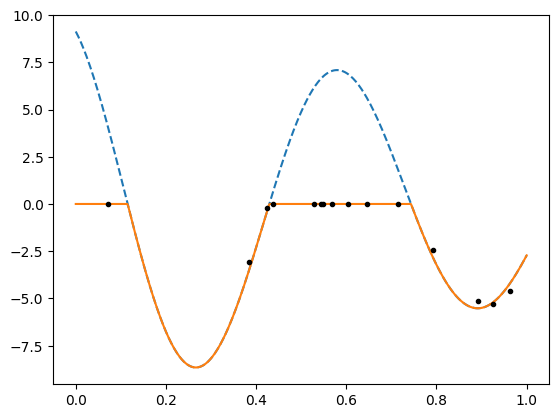

In [31]:
N_init = 15
np.random.seed(0)
x = torch.FloatTensor(np.random.rand(N_init))
torch.sort(x)
y = oracle(x)

domain = torch.linspace(0, 1, 500)
plt.plot(domain, noise_free_target(domain), '--');
plt.plot(domain, torch.clamp_max(noise_free_target(domain), 0), '-');
plt.plot(x, y, 'k.')

# ELBO Implementation

In [49]:
from gpytorch.models import ApproximateGP # handles basic variational inference
from gpytorch.variational import CholeskyVariationalDistribution # distribution of the approximation q(f)
from gpytorch.variational import VariationalStrategy # use when larger sample - transform q(u) to q(f) over inducing points

class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        # defines approximation
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points,
                                                   variational_distribution, learn_inducing_locations=False)
        super(GPModel, self).__init__(variational_strategy)
        # defines the GP
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


model = GPModel(inducing_points=x[:,None])
likelihood = CensoredGaussianLikelihoodAnalytic(low=-100., high=MAX_VALUE)

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

In [50]:
model.covar_module.base_kernel.initialize(lengthscale=0.5);
# model.covar_module.initialize(outputscale=1);
model.mean_module.initialize(constant=0)
#likelihood.noise.initialize(noise=1/10);

ConstantMean()

In [51]:
print_module(likelihood)
print_module(model)

noise.noise                         (1,)
[1.]
variational_strategy._variational_distribution.variational_mean (15,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
variational_strategy._variational_distribution.chol_variational_covar (15, 15)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
mean_module.constant                (

100%|██████████| 20000/20000 [04:00<00:00, 83.19it/s]


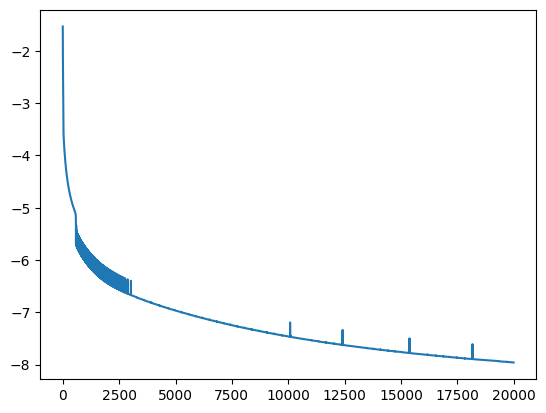

In [52]:
num_epochs = 20_000
pbar = tqdm.tqdm(range(num_epochs), position=0, leave=True)

model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y.size(0))

loss_list = list()
params_list = list()

for iter in pbar:
    optimizer.zero_grad();
    y_pred = model(x[:,None])
    loss = -mll(y_pred, y)
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())
    params_list.append(params_list)
plt.plot(loss_list)

In [53]:
print_module(likelihood)
print_module(model)

noise.noise                         (1,)
[141.8055]
variational_strategy._variational_distribution.variational_mean (15,)
[-2.0312872e-03  1.3416060e-04 -6.6177169e-04 -3.0265190e-04
  6.0041889e-04 -5.1279081e-04  7.7224402e-05  1.8055158e-03
  6.3507038e-04  2.6307100e-05 -2.6323710e-04 -2.6652240e-04
 -2.1627580e-04  1.5188160e-04 -4.0765011e-04]
variational_strategy._variational_distribution.chol_variational_covar (15, 15)
[[ 9.9988389e-01  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [-1.7137550e-04  9.9988848e-01  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 1.1698800e-05  4.9019000e-06  1.0000027e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000

In [54]:
model.variational_strategy._variational_distribution.variational_mean

Parameter containing:
tensor([-2.0313e-03,  1.3416e-04, -6.6177e-04, -3.0265e-04,  6.0042e-04,
        -5.1279e-04,  7.7224e-05,  1.8055e-03,  6.3507e-04,  2.6307e-05,
        -2.6324e-04, -2.6652e-04, -2.1628e-04,  1.5188e-04, -4.0765e-04],
       requires_grad=True)

In [55]:
model.eval()
likelihood.eval()

f_preds = model(domain[:,None])
y_preds = likelihood(f_preds)

f_mean = f_preds.loc
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix

N_samples = 1000
breakpoints = torch.linspace(0, 1, N_samples+1)[:-1]
breakpoints = breakpoints + breakpoints[1] * torch.rand_like(breakpoints)

with torch.no_grad():
    pred_samples = torch.distributions.Normal(f_mean, f_var.sqrt()).icdf(breakpoints[:,None])

/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(


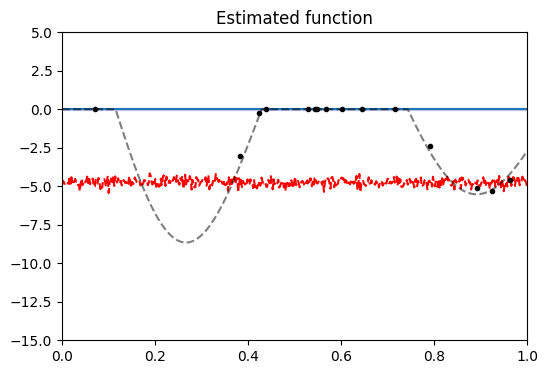

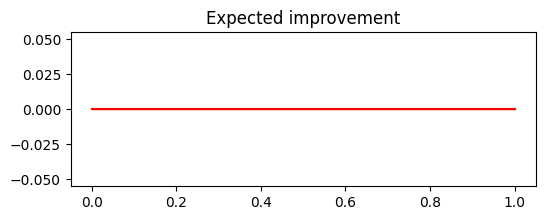

In [56]:
def plot_result(pred_samples, censored=False):
    if censored:
        c_pred = pred_samples > MAX_VALUE
        pred_samples[c_pred] = MAX_VALUE
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
      pred_median = np.median(pred_samples, axis=0)
      pred_quantiles = np.quantile(pred_samples, [0.025, 0.15, 0.85, 0.975], axis=0)

      plt.figure(figsize=(6, 4))
      plt.plot(domain, pred_median)

      plt.fill_between(domain, pred_quantiles[0], pred_quantiles[-1], alpha=0.1, color='#33c');
      plt.fill_between(domain, pred_quantiles[1], pred_quantiles[-2], alpha=0.1, color='#33c');
      plt.plot(domain, y_preds.sample_n(n=100).mean([0,1]).numpy(force=True), 'r--')

      plt.plot(x, y, 'k.');
      plt.plot(domain, noise_free_target(domain).clamp_max(MAX_VALUE), 'k--', alpha=0.5);
      plt.xlim(0, 1);
      plt.ylim(-15, 5);
      plt.title("Estimated function")

      plt.figure(figsize=(6, 2))
      plt.title("Expected improvement")
      EI =  -(pred_samples*(pred_samples < y.min()).float()).mean(0)
      plt.plot(domain, EI, 'r');
      plt.fill_between(domain, torch.zeros_like(domain), EI, color='r', alpha=0.5)

   # return f_covar, pred_samples

plot_result(pred_samples)

In [207]:
# u,d = f_preds.confidence_region()
# plt.plot(domain, f_preds.loc.numpy(force=True))
# plt.fill_between(domain, u.numpy(force=True), d.numpy(force=True), alpha=0.1, color='#33c')
# plt.plot(domain, y_preds.sample_n(n=100).mean([0,1]).numpy(force=True), 'r--')
# plt.plot(x, y, 'k.');
# plt.plot(domain, noise_free_target(domain).clamp_max(MAX_VALUE), 'k--', alpha=0.5);

# MC Simulation

In [17]:
from gpytorch.models import ApproximateGP # handles basic variational inference
from gpytorch.variational import CholeskyVariationalDistribution # distribution of the approximation q(f)
from gpytorch.variational import VariationalStrategy # use when larger sample - transform q(u) to q(f) over inducing points

class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        # defines approximation
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points,
                                                   variational_distribution, learn_inducing_locations=False)
        super(GPModel, self).__init__(variational_strategy)
        # defines the GP
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


model = GPModel(inducing_points=x[:,None])
# ElBO Likelihood
likelihood = CensoredGaussianLikelihood(low=-1000., high=MAX_VALUE)

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

In [18]:
print_module(model)

variational_strategy._variational_distribution.variational_mean (15,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
variational_strategy._variational_distribution.chol_variational_covar (15, 15)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
mean_module.constant                ()
0.0
covar_module.outputscale            ()
0

In [ ]:
num_epochs = 30000
pbar = tqdm.tqdm(range(num_epochs), position=0, leave=True)

model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y.size(0))

mae_list = list()
loss_list = list()

for iter in pbar:
    optimizer.zero_grad();
    y_pred = model(x[:,None])
    loss = -mll(y_pred, y)
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())

 51%|█████▏    | 15407/30000 [03:11<02:20, 103.62it/s]

In [ ]:
model.eval()
likelihood.eval()

f_preds = model(domain[:,None])
y_preds = likelihood(f_preds)

f_mean = f_preds.loc
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix

N_samples = 1000
breakpoints = torch.linspace(0, 1, N_samples+1)[:-1]
breakpoints = breakpoints + breakpoints[1] * torch.rand_like(breakpoints)

with torch.no_grad():
    pred_samples = torch.distributions.Normal(f_mean, f_var.sqrt()).icdf(breakpoints[:,None])

plot_result(pred_samples)